In [7]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

from epuc.helpers import *
from epuc.model import PredictorModel, BetaNN
from epuc.losses_beta import outer_bce_loss, inner_bce_loss
from epuc.train import train_model, train_multiple_models_primary_loss_beta, sample_predictions_secondary_beta

plt.style.use('seaborn-v0_8')

# Synthetic Experiments for Analysing the Quantification of Epistemic Uncertainty Quantification through Second Order Empirical Risk Minimization

## Simple Binary Classification Experiment

### 1. Test a neural network to learn a Bernoulli distribution

In [20]:
# set parameters
N_ITER = 100 # number of resampling iterations
N_EPOCHS = 500
LR = 0.0005
BATCH_SIZE = 128
lambda_reg = 1.0
loss_primary = nn.BCELoss()
loss_outer = outer_bce_loss(lambda_reg=0.0, estimate="analytical")
loss_outer_reg = outer_bce_loss(lambda_reg=lambda_reg, estimate="analytical")
loss_inner = inner_bce_loss(lambda_reg=0.0, estimate="analytical")
loss_inner_reg = inner_bce_loss(lambda_reg=lambda_reg, estimate="analytical")
N_SAMPLES_LIST = [100, 500, 10000]
sine_factor = 5


In [21]:
# dataset with instances and predictions for evaluation
dataset_eval = BernoulliSineDataset(n_samples=5000, sine_factor=sine_factor)
x_inst_eval = dataset_eval.x_inst
preds_eval = dataset_eval.preds
labels_eval = dataset_eval.y_labels

### Setting:

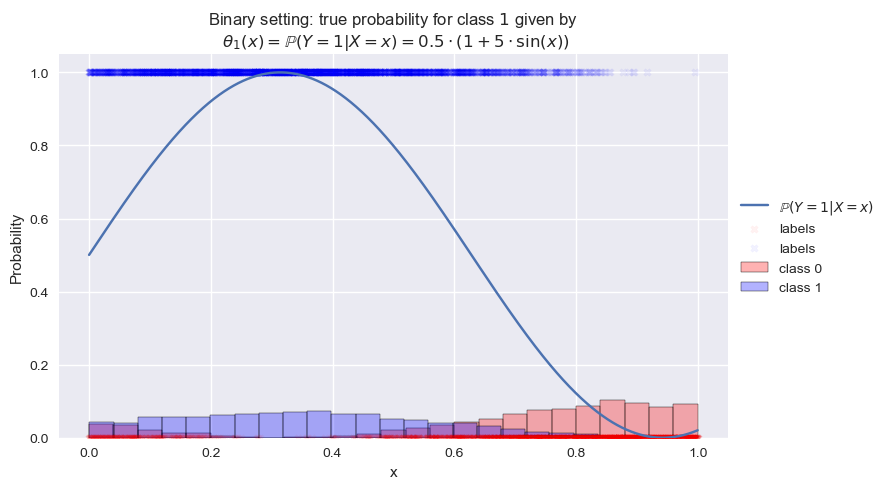

In [22]:
fig, ax = plt.subplots(figsize=(9, 5))
# order instances in increasing order
x_0 = x_inst_eval[np.where(labels_eval == 0)[0]]
x_1 = x_inst_eval[np.where(labels_eval == 1)[0]]
sns.histplot(x_0, kde=False, color="red", label="class 0", stat="probability", alpha=0.3, bins=25)
sns.histplot(x_1, kde=False, color="blue", label="class 1", stat="probability", alpha=0.3, bins=25)

# sort instances in increasing order
x_inst_eval_sorted = np.sort(x_inst_eval)
# sort labels and predictions accordingly
labels_eval_sorted = labels_eval[np.argsort(x_inst_eval)]
preds_eval_sorted = preds_eval[np.argsort(x_inst_eval)]

ax.plot(x_inst_eval_sorted, preds_eval_sorted, label="$\mathbb{P}(Y=1 | X=x)$")
ax.set_xlabel('x')
ax.scatter(x_0, np.zeros(len(x_0)), s=30, marker='X', color="red", alpha=0.05, label='labels')
ax.scatter(x_1, np.ones(len(x_1)), s=30, marker='X', color="blue", alpha=0.05, label='labels')
plt.title(f"Binary setting: true probability for class $1$ given by \n $ \\theta_1(x) = \mathbb{{P}}(Y=1|X=x) = 0.5 \cdot(1 + {{{sine_factor}}} \cdot \sin(x))$")
# plot legend in the best position
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

### 1. Primary Loss Minimisation:
Train $100$ different models to estimate predictive uncertainty for different amounts of training data.

Finished training for 100 samples.
Finished training for 500 samples.
Finished training for 5000 samples.


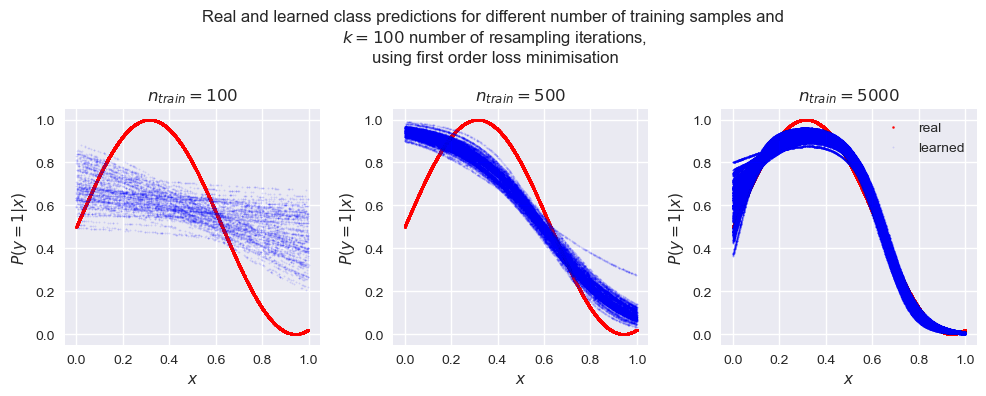

In [12]:
# plot real and learned probabilities for different number of samples
fig, ax = plt.subplots(1, 3, figsize=(10, 4))


for n_samples in N_SAMPLES_LIST:
    #plot real probabilitites
    ax.flatten()[N_SAMPLES_LIST.index(n_samples)].scatter(x_inst_eval, preds_eval, color="red", s=2,
                                                           label="real")
    # generate predictions of multiple models
    results_n, x_inst_n = train_multiple_models_primary_loss_beta(dataset=BernoulliSineDataset, n_samples=n_samples,
                                                            loss=loss, batch_size=BATCH_SIZE,
                                                            lr=LR, n_epochs=N_EPOCHS, n_runs=N_ITER,)
    # plot them in one subplot
    ax.flatten()[N_SAMPLES_LIST.index(n_samples)].scatter(x_inst_n, results_n,
                      s=1, alpha=0.1, color="blue", label="learned")
    print(f"Finished training for {n_samples} samples.")
    
    ax.flatten()[N_SAMPLES_LIST.index(n_samples)].set_title(f"$n_{{train}}={n_samples}$")
    ax.flatten()[N_SAMPLES_LIST.index(n_samples)].set_xlabel("$x$")
    ax.flatten()[N_SAMPLES_LIST.index(n_samples)].set_ylabel("$P(y=1|x)$")
   

plt.legend()
plt.suptitle("Real and learned class predictions for different number of training samples and \n"
             f"$k={{{N_ITER}}}$ number of resampling iterations, \n"
             "using first order loss minimisation")

plt.tight_layout()
plt.show()


## 2. Train BetaNN network to predict parameters for $Beta(\alpha, \beta)$ distribution using a second order loss:

### 2.1 outer loss minimization without regularization:

Finished training for 100 samples.
Finished training for 500 samples.
Finished training for 5000 samples.


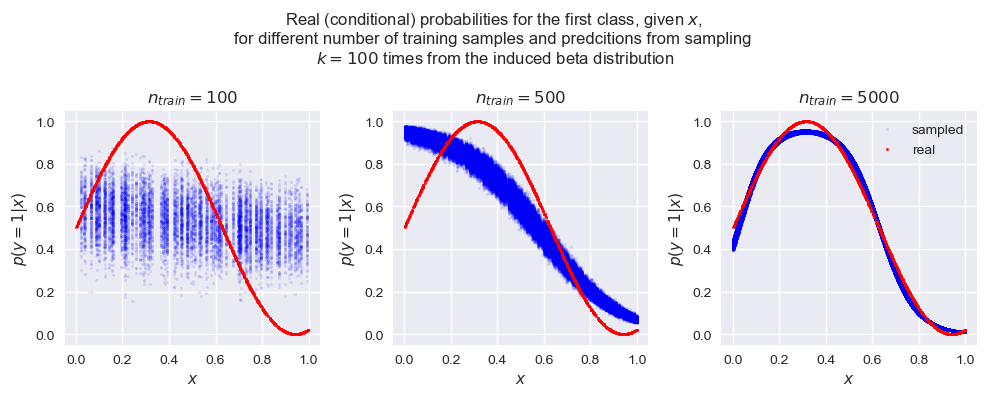

In [6]:
fig, ax = plt.subplots(1,3, figsize=(10, 4))

for n_samples in N_SAMPLES_LIST:
    model = BetaNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    dataset = BernoulliSineDataset(n_samples=n_samples)
    loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    model_out = train_model(model, loader, criterion=loss_outer, n_epochs= N_EPOCHS,
                            optim=optimizer)
    alphas, betas = model(dataset.x_inst.view(-1,1))
    # sample multiple times from the induced beta distribution

    results_n = sample_predictions_secondary_beta(alphas, betas, n_samplings=n_samples)
    x_inst = np.ones_like(results_n)*dataset.x_inst.numpy().squeeze()

    ax.flatten()[N_SAMPLES_LIST.index(n_samples)].scatter(x_inst,results_n, s=3, alpha=0.1, 
                                                            color="blue", label="sampled")
    
    print(f"Finished training for {n_samples} samples.")
    
    ax.flatten()[N_SAMPLES_LIST.index(n_samples)].set_title(f"$n_{{train}}={n_samples}$")
    ax.flatten()[N_SAMPLES_LIST.index(n_samples)].set_xlabel("$x$")
    ax.flatten()[N_SAMPLES_LIST.index(n_samples)].set_ylabel("$p(y=1|x)$")
    # plot real probabilities
    ax.flatten()[N_SAMPLES_LIST.index(n_samples)].scatter(x_inst_eval, preds_eval, color="red", s=3,
                                                           label="real")
    
plt.legend()
plt.suptitle("Real (conditional) probabilities for the first class, given $x$, \n"
             f" and predcitions from sampling \n"
             f"$k={{{N_ITER}}}$ times from the induced beta distribution, \n trained using outer loss minimization")
plt.tight_layout()

#### now same for analytical loss:

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10, 4))

for n_samples in N_SAMPLES_LIST:
    model = BetaNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    dataset = BernoulliSineDataset(n_samples=n_samples)
    loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    model_out = train_model(model, loader, criterion=loss_outer, n_epochs= N_EPOCHS,
                            optim=optimizer)
    alphas, betas = model(dataset.x_inst.view(-1,1))
    # sample multiple times from the induced beta distribution

    results_n = sample_predictions_secondary_beta(alphas, betas, n_samplings=n_samples)
    x_inst = np.ones_like(results_n)*dataset.x_inst.numpy().squeeze()

    ax.flatten()[N_SAMPLES_LIST.index(n_samples)].scatter(x_inst,results_n, s=3, alpha=0.1, 
                                                            color="blue", label="sampled")
    
    print(f"Finished training for {n_samples} samples.")
    
    ax.flatten()[N_SAMPLES_LIST.index(n_samples)].set_title(f"$n_{{train}}={n_samples}$")
    ax.flatten()[N_SAMPLES_LIST.index(n_samples)].set_xlabel("$x$")
    ax.flatten()[N_SAMPLES_LIST.index(n_samples)].set_ylabel("$p(y=1|x)$")
    # plot real probabilities
    ax.flatten()[N_SAMPLES_LIST.index(n_samples)].scatter(x_inst_eval, preds_eval, color="red", s=3,
                                                           label="real")
    
plt.legend()
plt.suptitle("Real (conditional) probabilities for the first class, given $x$, \n"
             f" and predcitions from sampling \n"
             f"$k={{{N_ITER}}}$ times from the induced beta distribution, \n trained using outer loss minimization")
plt.tight_layout()

### 2.2 outer loss minimization with regularization:

Finished training for 100 samples.
Finished training for 500 samples.
Finished training for 5000 samples.


/var/folders/mf/gnm849bj4fq5xnqhl_bdhf9m0000gn/T/ipykernel_5125/396455067.py:30: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


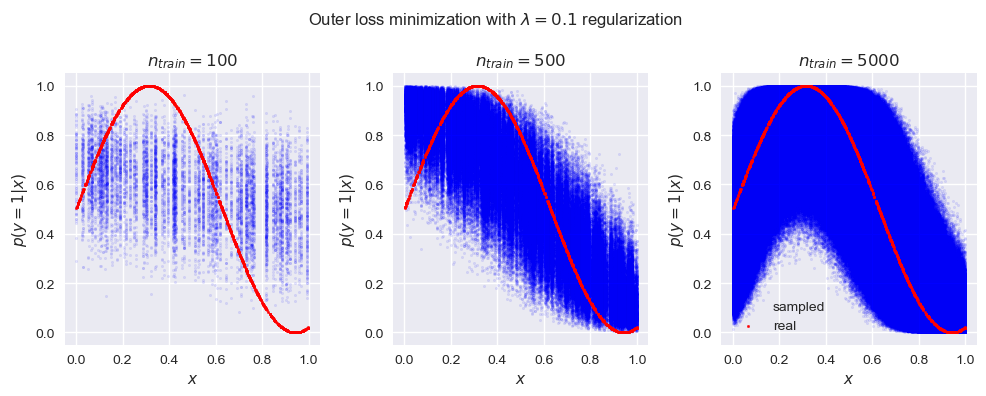

In [10]:
fig, ax = plt.subplots(1,3, figsize=(10, 4))

for n_samples in N_SAMPLES_LIST:
    model = BetaNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    dataset = BernoulliSineDataset(n_samples=n_samples)
    loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    model_out = train_model(model, loader, criterion=loss_outer_reg, n_epochs= N_EPOCHS,
                            optim=optimizer)
    alphas, betas = model(dataset.x_inst.view(-1,1))

    results_n = sample_predictions_secondary_beta(alphas, betas, n_samplings=n_samples)
    x_inst = np.ones_like(results_n)*dataset.x_inst.numpy().squeeze()

    ax.flatten()[N_SAMPLES_LIST.index(n_samples)].scatter(x_inst,results_n, s=3, alpha=0.1, 
                                                            color="blue", label="sampled")
    
    print(f"Finished training for {n_samples} samples.")
    
    ax.flatten()[N_SAMPLES_LIST.index(n_samples)].set_title(f"$n_{{train}}={n_samples}$")
    ax.flatten()[N_SAMPLES_LIST.index(n_samples)].set_xlabel("$x$")
    ax.flatten()[N_SAMPLES_LIST.index(n_samples)].set_ylabel("$p(y=1|x)$")
    # plot real probabilities
    ax.flatten()[N_SAMPLES_LIST.index(n_samples)].scatter(x_inst_eval, preds_eval, color="red", s=3,
                                                           label="real")
    
plt.legend()
plt.suptitle("Outer loss minimization with $\lambda=0.1$ regularization")

plt.tight_layout()

### 2.3 inner loss minimisation without regularization:

Finished training for 100 samples.
Finished training for 500 samples.
Finished training for 5000 samples.


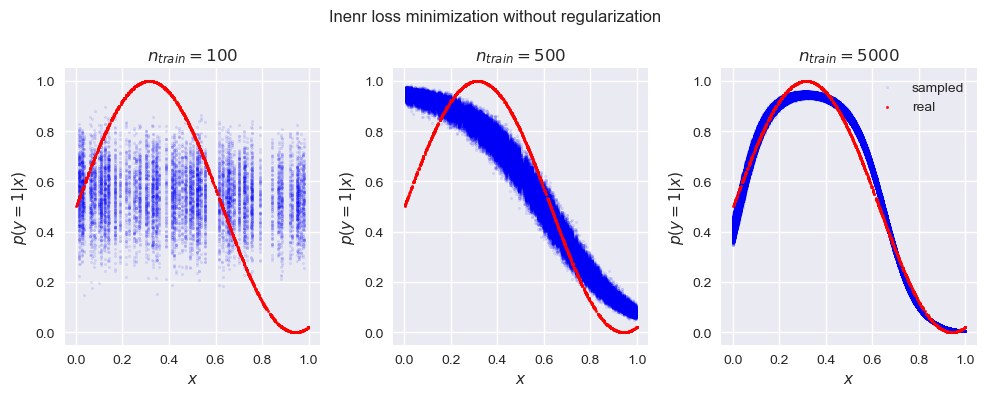

In [11]:
fig, ax = plt.subplots(1,3, figsize=(10, 4))

for n_samples in N_SAMPLES_LIST:
    model = BetaNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    dataset = BernoulliSineDataset(n_samples=n_samples)
    loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    model_out = train_model(model, loader, criterion=loss_inner, n_epochs= 400,
                            optim=optimizer)
    alphas, betas = model(dataset.x_inst.view(-1,1))

    results_n = sample_predictions_secondary_beta(alphas, betas, n_samplings=n_samples)
    x_inst = np.ones_like(results_n)*dataset.x_inst.numpy().squeeze()

    ax.flatten()[N_SAMPLES_LIST.index(n_samples)].scatter(x_inst,results_n, s=3, alpha=0.1, 
                                                            color="blue", label="sampled")
    
    print(f"Finished training for {n_samples} samples.")
    ax.flatten()[N_SAMPLES_LIST.index(n_samples)].set_title(f"$n_{{train}}={n_samples}$")
    ax.flatten()[N_SAMPLES_LIST.index(n_samples)].set_xlabel("$x$")
    ax.flatten()[N_SAMPLES_LIST.index(n_samples)].set_ylabel("$p(y=1|x)$")
    # plot real probabilities
    ax.flatten()[N_SAMPLES_LIST.index(n_samples)].scatter(x_inst_eval, preds_eval, color="red", s=3,
                                                           label="real")
    
plt.legend()
plt.suptitle("Inner loss minimization without regularization")
plt.tight_layout()

### 2.4 inner loss minimisation with regularization:

Finished training for 100 samples.
Finished training for 500 samples.
Finished training for 5000 samples.


/var/folders/mf/gnm849bj4fq5xnqhl_bdhf9m0000gn/T/ipykernel_5125/2411071780.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


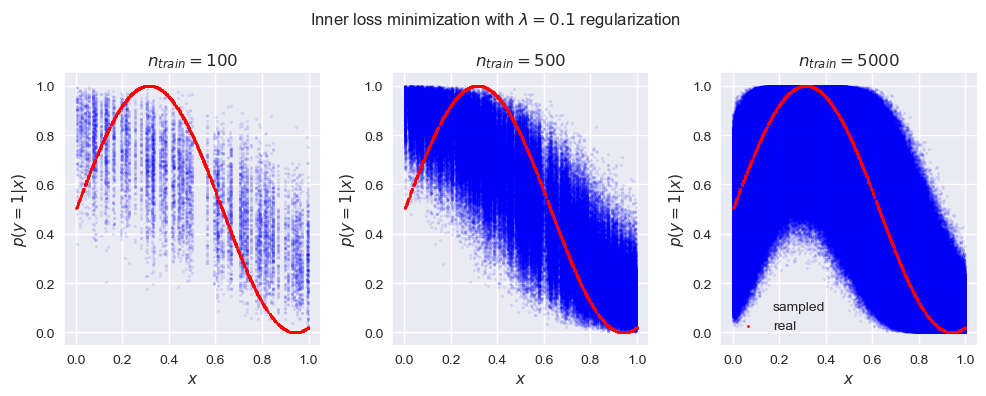

In [12]:
fig, ax = plt.subplots(1,3, figsize=(10, 4))

for n_samples in N_SAMPLES_LIST:
    model = BetaNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    dataset = BernoulliSineDataset(n_samples=n_samples)
    loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    model_out = train_model(model, loader, criterion=loss_inner_reg, n_epochs= N_EPOCHS,
                            optim=optimizer)
    alphas, betas = model(dataset.x_inst.view(-1,1))
    
    results_n = sample_predictions_secondary_beta(alphas, betas, n_samplings=n_samples)
    x_inst = np.ones_like(results_n)*dataset.x_inst.numpy().squeeze()

    ax.flatten()[N_SAMPLES_LIST.index(n_samples)].scatter(x_inst,results_n, s=3, alpha=0.1, 
                                                            color="blue", label="sampled")
    
    print(f"Finished training for {n_samples} samples.")
    
    ax.flatten()[N_SAMPLES_LIST.index(n_samples)].set_title(f"$n_{{train}}={n_samples}$")
    ax.flatten()[N_SAMPLES_LIST.index(n_samples)].set_xlabel("$x$")
    ax.flatten()[N_SAMPLES_LIST.index(n_samples)].set_ylabel("$p(y=1|x)$")
    # plot real probabilities
    ax.flatten()[N_SAMPLES_LIST.index(n_samples)].scatter(x_inst_eval, preds_eval, color="red", s=3,
                                                           label="real")
    
plt.legend()
plt.suptitle("Inner loss minimization with $\lambda=0.1$ regularization")
plt.tight_layout()

### 3. Calculate and visualize quantiles of first and second order loss minimisation results

### Now everything in one figure:

Finished first order loss minimnisation training for 100 samples.
Finished outer loss minimnisation training for 100 samples.
Finished outer loss minimnisation with regularization training for 100 samples.
Finished inner loss minimnisation training for 100 samples.
Finished inner loss minimnisation with regularization training for 100 samples.
Finished first order loss minimnisation training for 500 samples.
Finished outer loss minimnisation training for 500 samples.
Finished outer loss minimnisation with regularization training for 500 samples.
Finished inner loss minimnisation training for 500 samples.
Finished inner loss minimnisation with regularization training for 500 samples.
Finished first order loss minimnisation training for 5000 samples.
Finished outer loss minimnisation training for 5000 samples.
Finished outer loss minimnisation with regularization training for 5000 samples.
Finished inner loss minimnisation training for 5000 samples.
Finished inner loss minimnisation with

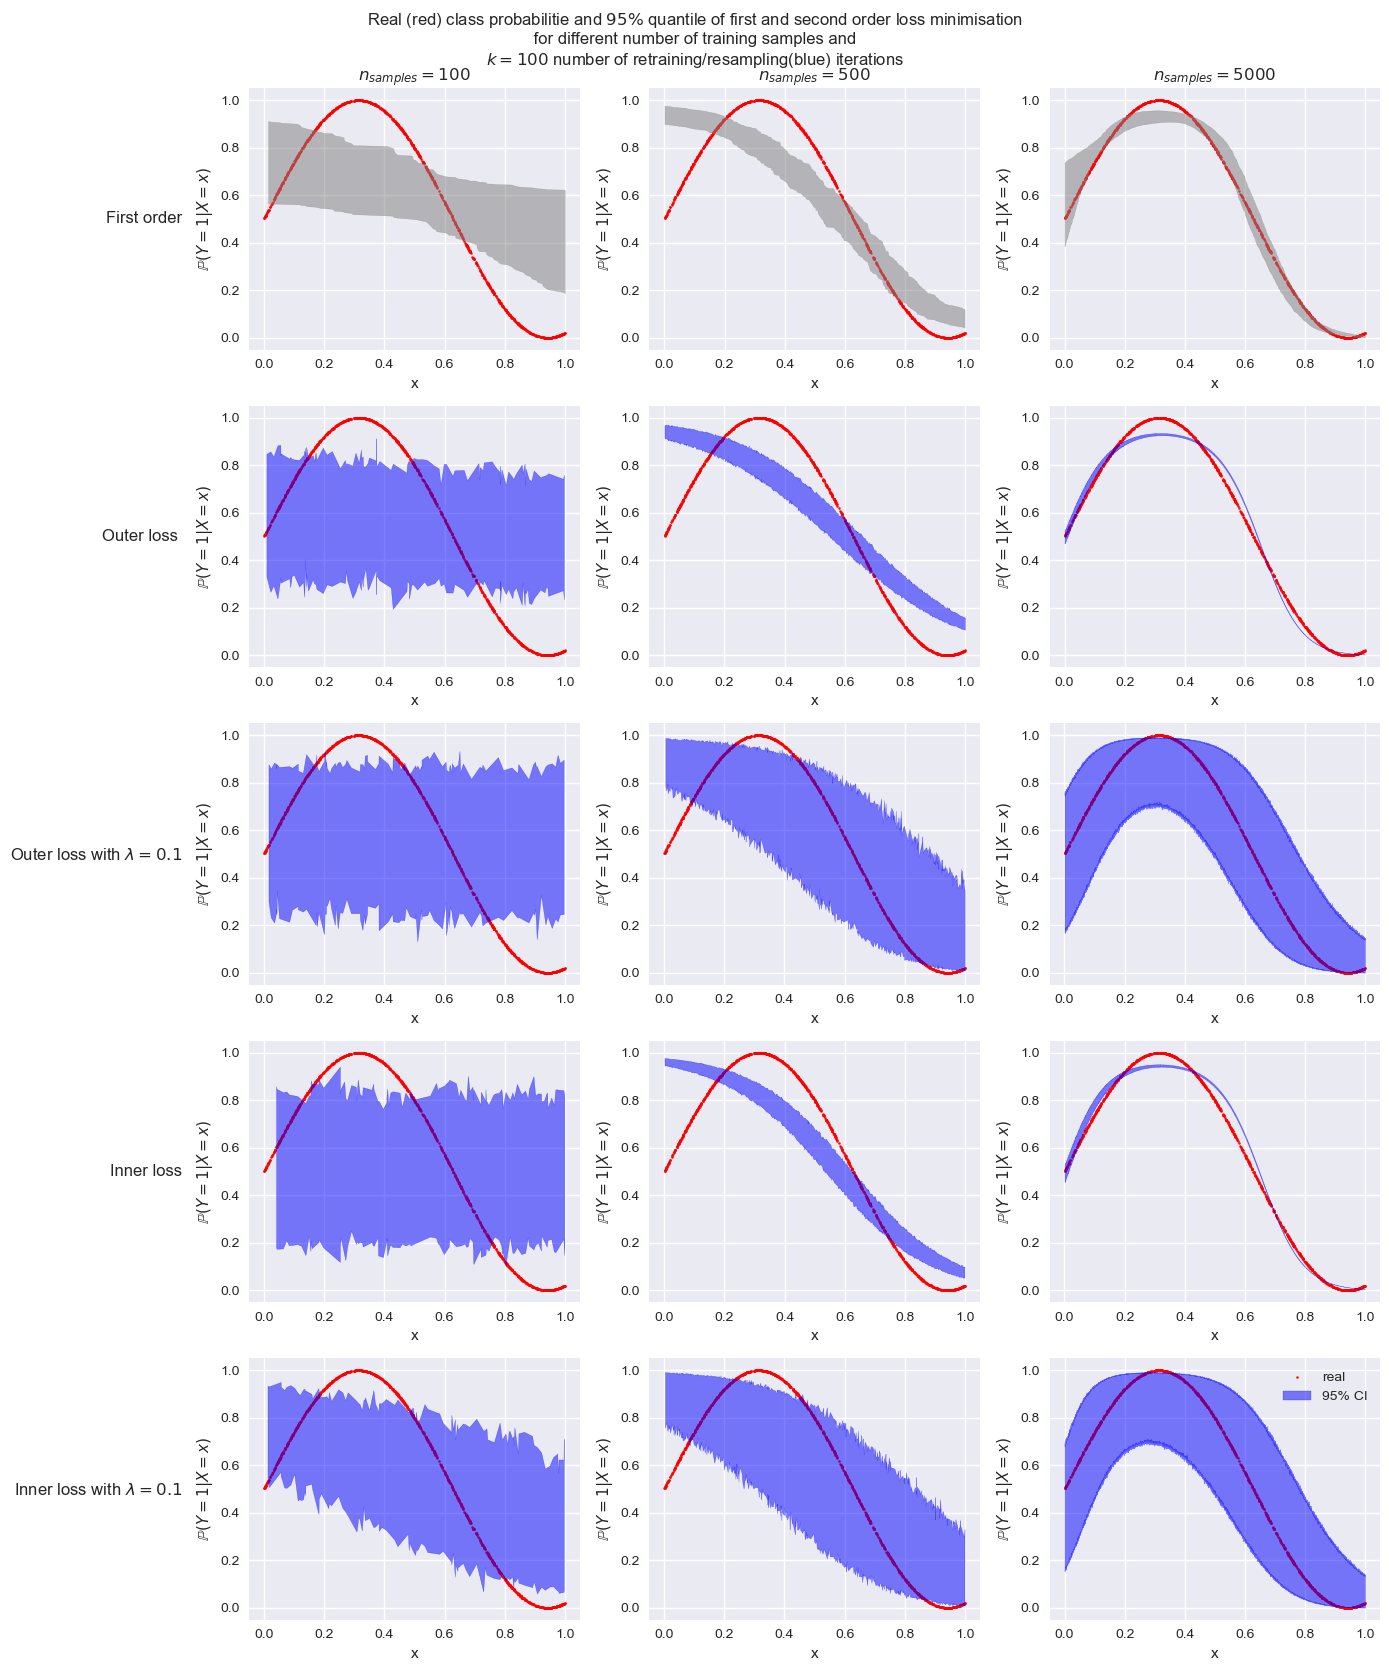

In [26]:
fig, ax = plt.subplots(5, 3, figsize=(14, 17))
# set x and y labels
plt.setp(ax.flat, xlabel='x', ylabel='$\mathbb{P}(Y=1|X=x)$')
row_names = ["First order", "Outer loss ", "Outer loss with $\lambda=0.1$", "Inner loss", "Inner loss with $\lambda=0.1$"]

# set row and column labels
for ax_sub, col in zip(ax[0], N_SAMPLES_LIST):
    ax_sub.annotate(f'$n_{{samples}}= {{{col}}}$', xy=(0.5, 1), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax_sub, row in zip(ax[:,0], row_names):
    ax_sub.annotate(row, xy=(0, 0.5), xytext=(-ax_sub.yaxis.labelpad - 5, 0),
                xycoords=ax_sub.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

# start training -------------------------------------------
for n_samples in N_SAMPLES_LIST:
    for idx in range(len(row_names)):
        #plot real probabilitites
        ax[idx, N_SAMPLES_LIST.index(n_samples)].scatter(x_inst_eval, preds_eval, color="red", s=2,
                                                              label="real")
        
    # FIRST ORDER LOSS MINIMISATION -----------------------------------------------
    # generate predictions of multiple models
    results_n, x_inst_n = train_multiple_models_primary_loss_beta(dataset=BernoulliSineDataset, n_samples=n_samples,
                                                            loss=loss, batch_size=BATCH_SIZE,
                                                            lr=LR, n_epochs=N_EPOCHS, n_runs=N_ITER,)
    # calculate mean and 2.5th and 97.5th percentiles
    results_n_mean = np.mean(results_n, axis=0)
    lower_quantile = np.percentile(results_n, 2.5, axis=0)
    upper_quantile = np.percentile(results_n, 97.5, axis=0)

    # plot them in one subplot
    ax[0, N_SAMPLES_LIST.index(n_samples)].fill_between(x_inst_n[0,:], lower_quantile, upper_quantile,
                      color="gray", alpha=0.5, label="95% CI")
    print(f"Finished first order loss minimnisation training for {n_samples} samples.")

    # OUTER LOSS MINIMISATION WITHOUT REGULARIZATION --------------------------------
    model = BetaNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    dataset = BernoulliSineDataset(n_samples=n_samples)
    loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    model_out = train_model(model, loader, criterion=loss_outer, n_epochs= N_EPOCHS,
                            optim=optimizer)
    alphas, betas = model(torch.sort(dataset.x_inst)[0].view(-1,1))
    # sample multiple times from the induced beta distribution

    results_n = sample_predictions_secondary_beta(alphas, betas, n_samplings=n_samples)
    x_inst = np.ones_like(results_n)*torch.sort(dataset.x_inst)[0].numpy().squeeze()

    # calculate mean and 2.5th and 97.5th percentiles
    results_n_mean = np.mean(results_n, axis=0)
    lower_quantile = np.percentile(results_n, 2.5, axis=0)
    upper_quantile = np.percentile(results_n, 97.5, axis=0)

    # plot them in one subplot
    ax[1, N_SAMPLES_LIST.index(n_samples)].fill_between(x_inst[0,:], lower_quantile, upper_quantile,
                      color="blue", alpha=0.5, label="95% CI")

    print(f"Finished outer loss minimnisation training for {n_samples} samples.")

    # OUTER LOSS MINIMISATION WITH REGULARIZATION --------------------------------
    model = BetaNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    dataset = BernoulliSineDataset(n_samples=n_samples)
    loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    model_out = train_model(model, loader, criterion=loss_outer_reg, n_epochs= N_EPOCHS,
                            optim=optimizer)
    alphas, betas = model(torch.sort(dataset.x_inst)[0].view(-1,1))
    # sample multiple times from the induced beta distribution
    results_n = sample_predictions_secondary_beta(alphas, betas, n_samplings=n_samples)
    x_inst = np.ones_like(results_n)*torch.sort(dataset.x_inst)[0].numpy().squeeze()

    # calculate mean and 2.5th and 97.5th percentiles
    results_n_mean = np.mean(results_n, axis=0)
    lower_quantile = np.percentile(results_n, 2.5, axis=0)
    upper_quantile = np.percentile(results_n, 97.5, axis=0)

    # plot them in one subplot
    ax[2, N_SAMPLES_LIST.index(n_samples)].fill_between(x_inst[0,:], lower_quantile, upper_quantile,
                      color="blue", alpha=0.5, label="95% CI")
    
    print(f"Finished outer loss minimnisation with regularization training for {n_samples} samples.")

    # INNER LOSS MINIMISATION WITHOUT REGULARIZATION --------------------------------
    model = BetaNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    dataset = BernoulliSineDataset(n_samples=n_samples)
    loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    model_out = train_model(model, loader, criterion=loss_inner, n_epochs= N_EPOCHS,
                            optim=optimizer)
    alphas, betas = model(torch.sort(dataset.x_inst)[0].view(-1,1))
    # sample multiple times from the induced beta distribution
    results_n = sample_predictions_secondary_beta(alphas, betas, n_samplings=n_samples)
    x_inst = np.ones_like(results_n)*torch.sort(dataset.x_inst)[0].numpy().squeeze()

    # calculate mean and 2.5th and 97.5th percentiles
    results_n_mean = np.mean(results_n, axis=0)
    lower_quantile = np.percentile(results_n, 2.5, axis=0)
    upper_quantile = np.percentile(results_n, 97.5, axis=0)

    # plot them in one subplot
    ax[3, N_SAMPLES_LIST.index(n_samples)].fill_between(x_inst[0,:], lower_quantile, upper_quantile,
                      color="blue", alpha=0.5, label="95% CI")
    
    print(f"Finished inner loss minimnisation training for {n_samples} samples.")

    # INNER LOSS MINIMISATION WITH REGULARIZATION --------------------------------
    model = BetaNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    dataset = BernoulliSineDataset(n_samples=n_samples)
    loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    model_out = train_model(model, loader, criterion=loss_inner_reg, n_epochs= N_EPOCHS,
                            optim=optimizer)
    alphas, betas = model(torch.sort(dataset.x_inst)[0].view(-1,1))
    # sample multiple times from the induced beta distribution
    results_n = sample_predictions_secondary_beta(alphas, betas, n_samplings=n_samples)
    x_inst = np.ones_like(results_n)*torch.sort(dataset.x_inst)[0].numpy().squeeze()

    # calculate mean and 2.5th and 97.5th percentiles
    results_n_mean = np.mean(results_n, axis=0)
    lower_quantile = np.percentile(results_n, 2.5, axis=0)
    upper_quantile = np.percentile(results_n, 97.5, axis=0)

    # plot them in one subplot
    ax[4, N_SAMPLES_LIST.index(n_samples)].fill_between(x_inst[0,:], lower_quantile, upper_quantile,
                      color="blue", alpha=0.5, label="95% CI")
    
    print(f"Finished inner loss minimnisation with regularization training for {n_samples} samples.")

plt.legend()
plt.suptitle("Real (red) class probabilitie and $95\%$ quantile of first and second order loss minimisation \n"
             " for different number of training samples and \n"
             f"$k={{{N_ITER}}}$ number of retraining/resampling(blue) iterations")

plt.tight_layout()

### New training with analytical loss functions:

Finished first order loss minimnisation training for 100 samples.
Finished outer loss minimnisation training for 100 samples.
Finished outer loss minimnisation with regularization training for 100 samples.
Finished inner loss minimnisation training for 100 samples.
Finished inner loss minimnisation with regularization training for 100 samples.
Finished first order loss minimnisation training for 500 samples.
Finished outer loss minimnisation training for 500 samples.
Finished outer loss minimnisation with regularization training for 500 samples.
Finished inner loss minimnisation training for 500 samples.
Finished inner loss minimnisation with regularization training for 500 samples.
Finished first order loss minimnisation training for 10000 samples.
Finished outer loss minimnisation training for 10000 samples.
Finished outer loss minimnisation with regularization training for 10000 samples.
Finished inner loss minimnisation training for 10000 samples.
Finished inner loss minimnisation 

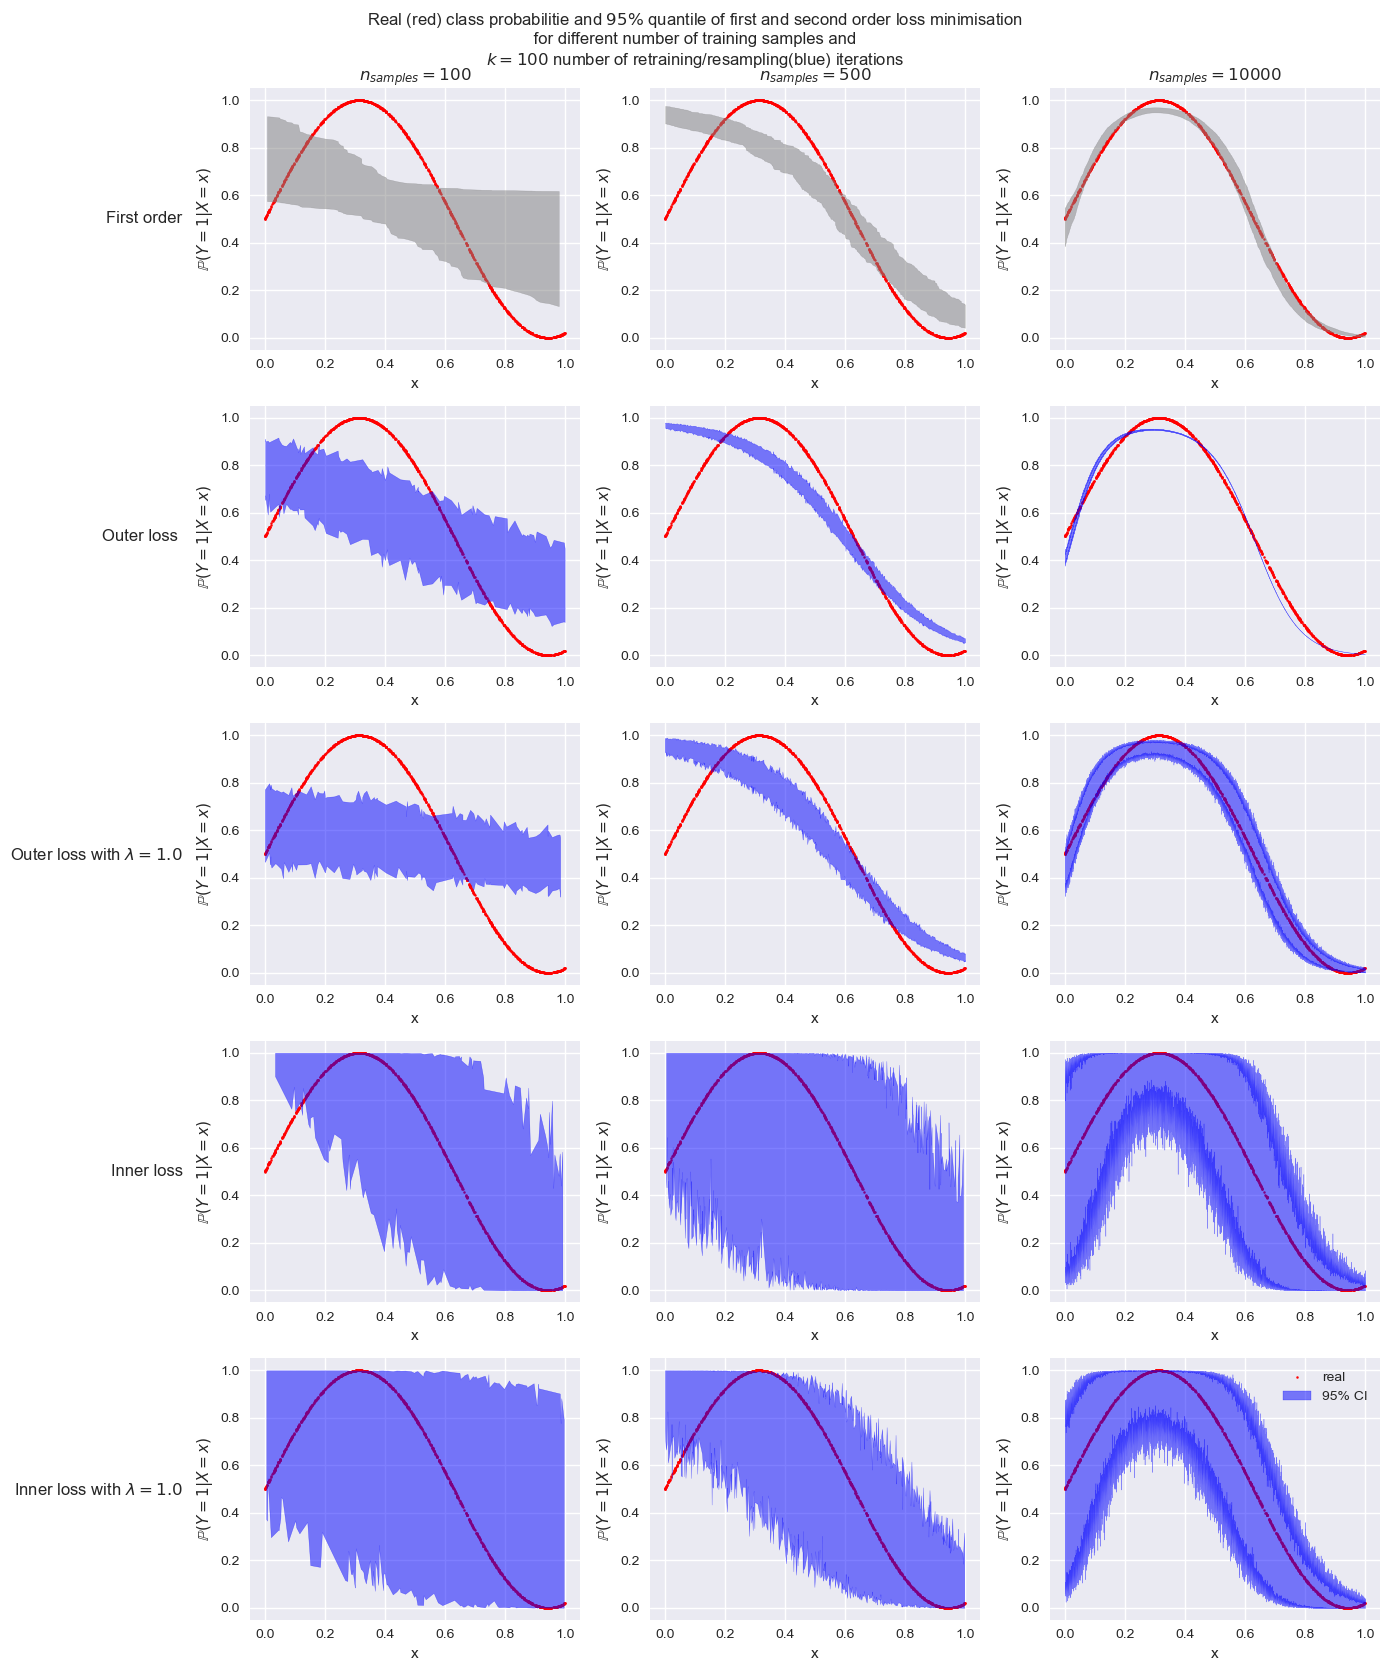

In [47]:
fig, ax = plt.subplots(5, 3, figsize=(14, 17))
# set x and y labels
plt.setp(ax.flat, xlabel='x', ylabel='$\mathbb{P}(Y=1|X=x)$')
row_names = ["First order", "Outer loss ", f"Outer loss with $\lambda={{{lambda_reg}}}$", "Inner loss", f"Inner loss with $\lambda={{{lambda_reg}}}$"]

# set row and column labels
for ax_sub, col in zip(ax[0], N_SAMPLES_LIST):
    ax_sub.annotate(f'$n_{{samples}}= {{{col}}}$', xy=(0.5, 1), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax_sub, row in zip(ax[:,0], row_names):
    ax_sub.annotate(row, xy=(0, 0.5), xytext=(-ax_sub.yaxis.labelpad - 5, 0),
                xycoords=ax_sub.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

# start training -------------------------------------------
for n_samples in N_SAMPLES_LIST:
    for idx in range(len(row_names)):
        #plot real probabilitites
        ax[idx, N_SAMPLES_LIST.index(n_samples)].scatter(x_inst_eval, preds_eval, color="red", s=2,
                                                              label="real")
        
    # FIRST ORDER LOSS MINIMISATION -----------------------------------------------
    # generate predictions of multiple models
    results_n, x_inst_n = train_multiple_models_primary_loss_beta(dataset=BernoulliSineDataset, n_samples=n_samples,
                                                            loss=loss_primary, batch_size=BATCH_SIZE,
                                                            lr=LR, n_epochs=N_EPOCHS, n_runs=N_ITER,)
    # calculate mean and 2.5th and 97.5th percentiles
    results_n_mean = np.mean(results_n, axis=0)
    lower_quantile = np.percentile(results_n, 2.5, axis=0)
    upper_quantile = np.percentile(results_n, 97.5, axis=0)

    # plot them in one subplot
    ax[0, N_SAMPLES_LIST.index(n_samples)].fill_between(x_inst_n[0,:], lower_quantile, upper_quantile,
                      color="gray", alpha=0.5, label="95% CI")
    print(f"Finished first order loss minimnisation training for {n_samples} samples.")

    # OUTER LOSS MINIMISATION WITHOUT REGULARIZATION --------------------------------
    model = BetaNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    dataset = BernoulliSineDataset(n_samples=n_samples)
    loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    model_out = train_model(model, loader, criterion=loss_outer, n_epochs= N_EPOCHS,
                            optim=optimizer)
    alphas, betas = model(torch.sort(dataset.x_inst)[0].view(-1,1))
    # sample multiple times from the induced beta distribution

    results_n = sample_predictions_secondary_beta(alphas, betas, n_samplings=N_ITER)
    x_inst = np.ones_like(results_n)*torch.sort(dataset.x_inst)[0].numpy().squeeze()

    # calculate mean and 2.5th and 97.5th percentiles
    results_n_mean = np.mean(results_n, axis=0)
    lower_quantile = np.percentile(results_n, 2.5, axis=0)
    upper_quantile = np.percentile(results_n, 97.5, axis=0)

    # plot them in one subplot
    ax[1, N_SAMPLES_LIST.index(n_samples)].fill_between(x_inst[0,:], lower_quantile, upper_quantile,
                      color="blue", alpha=0.5, label="95% CI")

    print(f"Finished outer loss minimnisation training for {n_samples} samples.")

    # OUTER LOSS MINIMISATION WITH REGULARIZATION --------------------------------
    model = BetaNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    dataset = BernoulliSineDataset(n_samples=n_samples)
    loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    model_out = train_model(model, loader, criterion=loss_outer_reg, n_epochs= N_EPOCHS,
                            optim=optimizer)
    alphas, betas = model(torch.sort(dataset.x_inst)[0].view(-1,1))
    # sample multiple times from the induced beta distribution
    results_n = sample_predictions_secondary_beta(alphas, betas, n_samplings=N_ITER)
    x_inst = np.ones_like(results_n)*torch.sort(dataset.x_inst)[0].numpy().squeeze()

    # calculate mean and 2.5th and 97.5th percentiles
    results_n_mean = np.mean(results_n, axis=0)
    lower_quantile = np.percentile(results_n, 2.5, axis=0)
    upper_quantile = np.percentile(results_n, 97.5, axis=0)

    # plot them in one subplot
    ax[2, N_SAMPLES_LIST.index(n_samples)].fill_between(x_inst[0,:], lower_quantile, upper_quantile,
                      color="blue", alpha=0.5, label="95% CI")
    
    print(f"Finished outer loss minimnisation with regularization training for {n_samples} samples.")

    # INNER LOSS MINIMISATION WITHOUT REGULARIZATION --------------------------------
    model = BetaNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    dataset = BernoulliSineDataset(n_samples=n_samples)
    loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    model_out = train_model(model, loader, criterion=loss_inner, n_epochs= N_EPOCHS,
                            optim=optimizer)
    alphas, betas = model(torch.sort(dataset.x_inst)[0].view(-1,1))
    # sample multiple times from the induced beta distribution
    results_n = sample_predictions_secondary_beta(alphas, betas, n_samplings=N_ITER)
    x_inst = np.ones_like(results_n)*torch.sort(dataset.x_inst)[0].numpy().squeeze()

    # calculate mean and 2.5th and 97.5th percentiles
    results_n_mean = np.mean(results_n, axis=0)
    lower_quantile = np.percentile(results_n, 2.5, axis=0)
    upper_quantile = np.percentile(results_n, 97.5, axis=0)

    # plot them in one subplot
    ax[3, N_SAMPLES_LIST.index(n_samples)].fill_between(x_inst[0,:], lower_quantile, upper_quantile,
                      color="blue", alpha=0.5, label="95% CI")
    
    print(f"Finished inner loss minimnisation training for {n_samples} samples.")

    # INNER LOSS MINIMISATION WITH REGULARIZATION --------------------------------
    model = BetaNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    dataset = BernoulliSineDataset(n_samples=n_samples)
    loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    model_out = train_model(model, loader, criterion=loss_inner_reg, n_epochs= N_EPOCHS,
                            optim=optimizer)
    alphas, betas = model(torch.sort(dataset.x_inst)[0].view(-1,1))
    # sample multiple times from the induced beta distribution
    results_n = sample_predictions_secondary_beta(alphas, betas, n_samplings=N_ITER)
    x_inst = np.ones_like(results_n)*torch.sort(dataset.x_inst)[0].numpy().squeeze()

    # calculate mean and 2.5th and 97.5th percentiles
    results_n_mean = np.mean(results_n, axis=0)
    lower_quantile = np.percentile(results_n, 2.5, axis=0)
    upper_quantile = np.percentile(results_n, 97.5, axis=0)

    # plot them in one subplot
    ax[4, N_SAMPLES_LIST.index(n_samples)].fill_between(x_inst[0,:], lower_quantile, upper_quantile,
                      color="blue", alpha=0.5, label="95% CI")
    
    print(f"Finished inner loss minimnisation with regularization training for {n_samples} samples.")

plt.legend()
plt.suptitle("Real (red) class probabilitie and $95\%$ quantile of first and second order loss minimisation \n"
             " for different number of training samples and \n"
             f"$k={{{N_ITER}}}$ number of retraining/resampling(blue) iterations")

plt.tight_layout()

In [50]:
model = BetaNN()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
dataset = BernoulliSineDataset(n_samples=10000)
loader = torch.utils.data.DataLoader(dataset, batch_size=500, shuffle=True)
model_out = train_model(model, loader, criterion=loss_inner_reg, n_epochs= N_EPOCHS,
                        optim=optimizer)
alphas, betas = model(torch.sort(dataset.x_inst)[0].view(-1,1))
# sample multiple times from the induced beta distribution
results_n = sample_predictions_secondary_beta(alphas, betas, n_samplings=100)
x_inst_matrix = np.ones_like(results_n)*torch.sort(dataset.x_inst)[0].numpy().squeeze()

# calculate mean and 2.5th and 97.5th percentiles
results_n_mean = np.mean(results_n, axis=0)
lower_quantile = np.percentile(results_n, 2.5, axis=0)
upper_quantile = np.percentile(results_n, 97.5, axis=0)


Finished first order loss minimnisation training for 1000 samples.
Finished outer loss minimnisation training for 1000 samples.
Finished outer loss minimnisation with regularization training for 1000 samples.
Finished inner loss minimnisation training for 1000 samples.
Finished inner loss minimnisation with regularization training for 1000 samples.
Finished first order loss minimnisation training for 5000 samples.
Finished outer loss minimnisation training for 5000 samples.
Finished outer loss minimnisation with regularization training for 5000 samples.
Finished inner loss minimnisation training for 5000 samples.
Finished inner loss minimnisation with regularization training for 5000 samples.


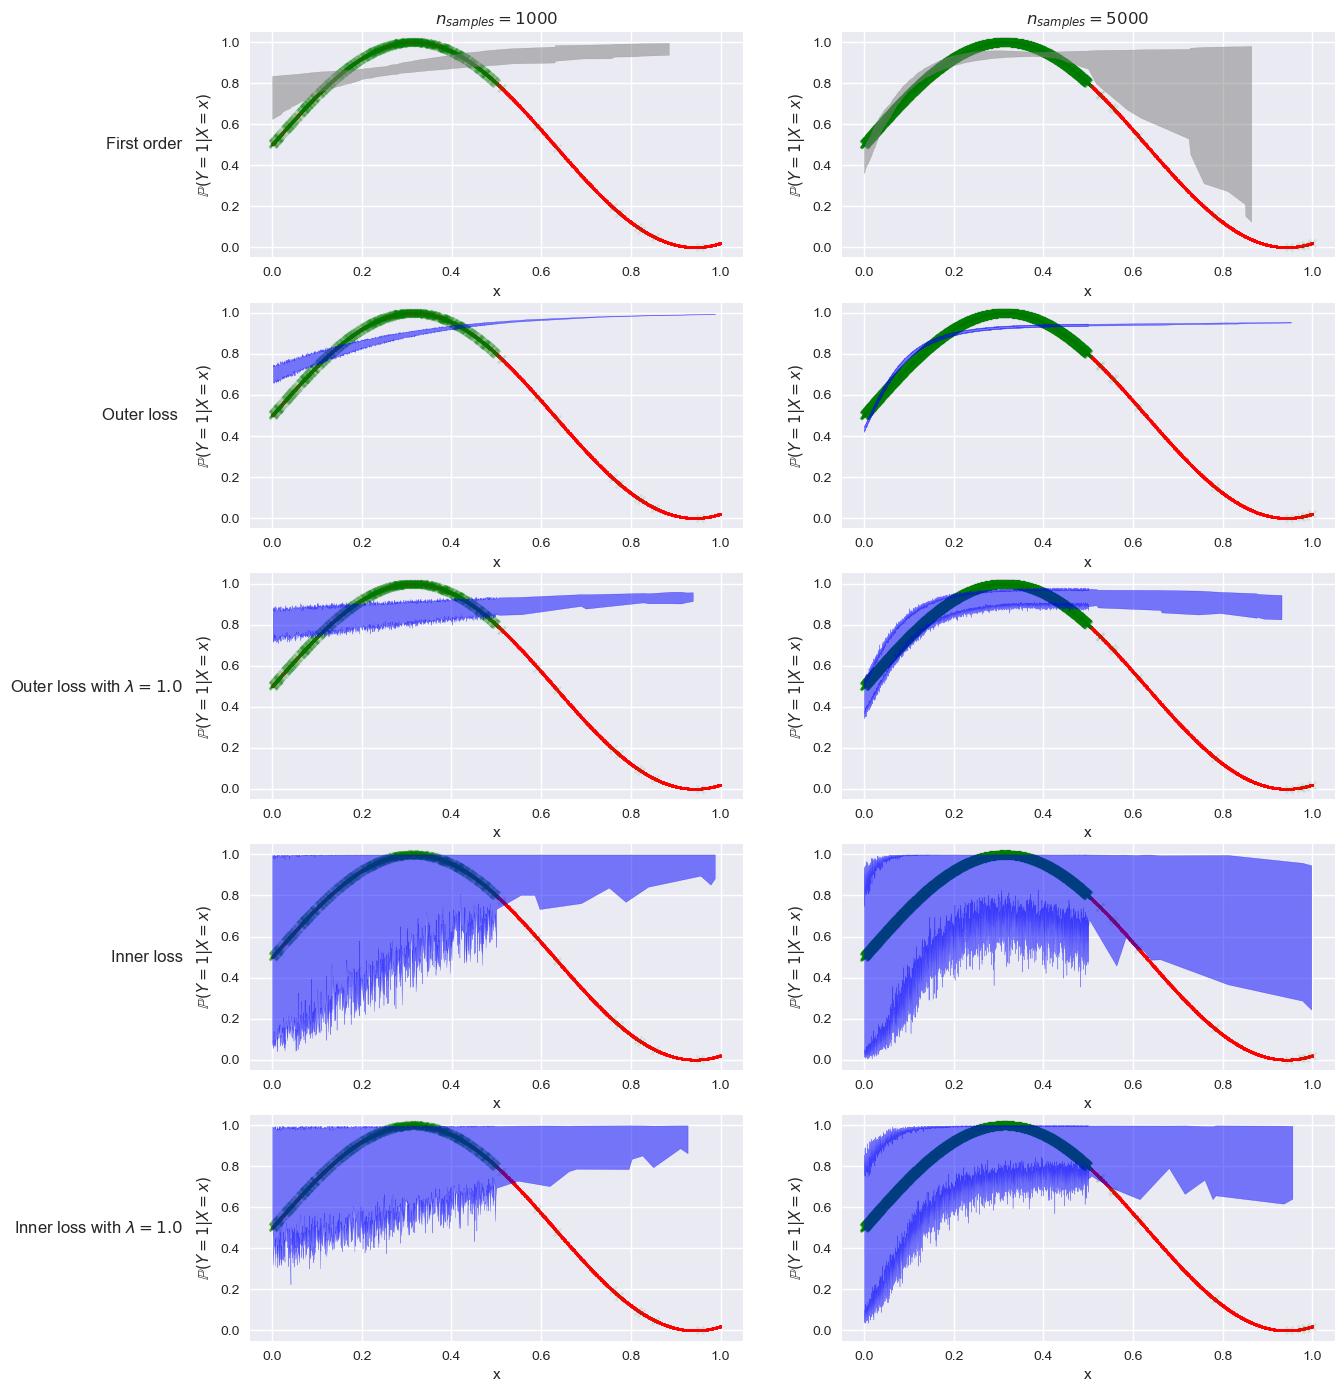

In [24]:

N_SAMPLES_LIST = [1000, 5000]
fig, ax = plt.subplots(5, 2, figsize=(14, 17))
# set x and y labels
plt.setp(ax.flat, xlabel='x', ylabel='$\mathbb{P}(Y=1|X=x)$')
row_names = ["First order", "Outer loss ", f"Outer loss with $\lambda={{{lambda_reg}}}$", "Inner loss", f"Inner loss with $\lambda={{{lambda_reg}}}$"]

# set row and column labels
for ax_sub, col in zip(ax[0], N_SAMPLES_LIST):
    ax_sub.annotate(f'$n_{{samples}}= {{{col}}} + 10$', xy=(0.5, 1), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax_sub, row in zip(ax[:,0], row_names):
    ax_sub.annotate(row, xy=(0, 0.5), xytext=(-ax_sub.yaxis.labelpad - 5, 0),
                xycoords=ax_sub.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

# start training -------------------------------------------
for n_samples in N_SAMPLES_LIST:
    dataset = BernoulliSineDatasetsplitted(n_samples_1=n_samples, n_samples_2=10)
    x_inst = dataset.x_inst.numpy().squeeze()
    preds = dataset.preds.numpy().squeeze()
    
    for idx in range(len(row_names)):
        #plot real probabilitites
        ax[idx, N_SAMPLES_LIST.index(n_samples)].scatter(x_inst_eval, preds_eval, color="red", s=2,
                                                              label="real $\theta_1$")
        ax[idx, N_SAMPLES_LIST.index(n_samples)].scatter(x_inst, preds, color="green", s=30,
                                                                label="samples", marker="x", alpha=0.5)
        
    # FIRST ORDER LOSS MINIMISATION -----------------------------------------------
    results_n, x_inst_n = train_multiple_models_primary_loss_beta(dataset=BernoulliSineDatasetsplitted,
                                                                   n_samples=n_samples,
                                                                   n_samples_2=10,
                                                            loss=loss_primary, batch_size=BATCH_SIZE,
                                                            lr=LR, n_epochs=N_EPOCHS, n_runs=N_ITER,)
    # calculate mean and 2.5th and 97.5th percentiles
    results_n_mean = np.mean(results_n, axis=0)
    lower_quantile = np.percentile(results_n, 2.5, axis=0)
    upper_quantile = np.percentile(results_n, 97.5, axis=0)

    # plot them in one subplot
    ax[0, N_SAMPLES_LIST.index(n_samples)].fill_between(x_inst_n[0,:], lower_quantile, upper_quantile,
                      color="gray", alpha=0.5, label="95% CI")
    print(f"Finished first order loss minimnisation training for {n_samples} samples.")

    # OUTER LOSS MINIMISATION WITHOUT REGULARIZATION --------------------------------
    model = BetaNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    dataset = BernoulliSineDatasetsplitted(n_samples_1=n_samples, n_samples_2=10)
    loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    model_out = train_model(model, loader, criterion=loss_outer, n_epochs= N_EPOCHS,
                            optim=optimizer)
    alphas, betas = model(torch.sort(dataset.x_inst)[0].view(-1,1))
    # sample multiple times from the induced beta distribution

    results_n = sample_predictions_secondary_beta(alphas, betas, n_samplings=N_ITER)
    x_inst = np.ones_like(results_n)*torch.sort(dataset.x_inst)[0].numpy().squeeze()

    # calculate mean and 2.5th and 97.5th percentiles
    results_n_mean = np.mean(results_n, axis=0)
    lower_quantile = np.percentile(results_n, 2.5, axis=0)
    upper_quantile = np.percentile(results_n, 97.5, axis=0)

    # plot them in one subplot
    ax[1, N_SAMPLES_LIST.index(n_samples)].fill_between(x_inst[0,:], lower_quantile, upper_quantile,
                        color="blue", alpha=0.5, label="95% CI")
    print(f"Finished outer loss minimnisation training for {n_samples} samples.")

    # OUTER LOSS MINIMISATION WITH REGULARIZATION --------------------------------
    model = BetaNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    dataset = BernoulliSineDatasetsplitted(n_samples_1=n_samples, n_samples_2=10)
    loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    model_out = train_model(model, loader, criterion=loss_outer_reg, n_epochs= N_EPOCHS,
                            optim=optimizer)
    alphas, betas = model(torch.sort(dataset.x_inst)[0].view(-1,1))
    # sample multiple times from the induced beta distribution
    results_n = sample_predictions_secondary_beta(alphas, betas, n_samplings=N_ITER)
    x_inst = np.ones_like(results_n)*torch.sort(dataset.x_inst)[0].numpy().squeeze()

    # calculate mean and 2.5th and 97.5th percentiles
    results_n_mean = np.mean(results_n, axis=0)
    lower_quantile = np.percentile(results_n, 2.5, axis=0)
    upper_quantile = np.percentile(results_n, 97.5, axis=0)

    # plot them in one subplot
    ax[2, N_SAMPLES_LIST.index(n_samples)].fill_between(x_inst[0,:], lower_quantile, upper_quantile,
                        color="blue", alpha=0.5, label="95% CI")
    
    print(f"Finished outer loss minimnisation with regularization training for {n_samples} samples.")

    # INNER LOSS MINIMISATION WITHOUT REGULARIZATION --------------------------------
    model = BetaNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    dataset = BernoulliSineDatasetsplitted(n_samples_1=n_samples, n_samples_2=10)
    loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    model_out = train_model(model, loader, criterion=loss_inner, n_epochs= N_EPOCHS,
                            optim=optimizer)
    alphas, betas = model(torch.sort(dataset.x_inst)[0].view(-1,1))
    # sample multiple times from the induced beta distribution
    results_n = sample_predictions_secondary_beta(alphas, betas, n_samplings=N_ITER)
    x_inst = np.ones_like(results_n)*torch.sort(dataset.x_inst)[0].numpy().squeeze()

    # calculate mean and 2.5th and 97.5th percentiles
    results_n_mean = np.mean(results_n, axis=0)
    lower_quantile = np.percentile(results_n, 2.5, axis=0)
    upper_quantile = np.percentile(results_n, 97.5, axis=0)

    # plot them in one subplot
    ax[3, N_SAMPLES_LIST.index(n_samples)].fill_between(x_inst[0,:], lower_quantile, upper_quantile,
                        color="blue", alpha=0.5, label="95% CI")
    
    print(f"Finished inner loss minimnisation training for {n_samples} samples.")

    # INNER LOSS MINIMISATION WITH REGULARIZATION --------------------------------
    model = BetaNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    dataset = BernoulliSineDatasetsplitted(n_samples_1=n_samples, n_samples_2=10)
    loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    model_out = train_model(model, loader, criterion=loss_inner_reg, n_epochs= N_EPOCHS,
                            optim=optimizer)
    alphas, betas = model(torch.sort(dataset.x_inst)[0].view(-1,1))
    # sample multiple times from the induced beta distribution
    results_n = sample_predictions_secondary_beta(alphas, betas, n_samplings=N_ITER)
    x_inst = np.ones_like(results_n)*torch.sort(dataset.x_inst)[0].numpy().squeeze()

    # calculate mean and 2.5th and 97.5th percentiles
    results_n_mean = np.mean(results_n, axis=0)
    lower_quantile = np.percentile(results_n, 2.5, axis=0)
    upper_quantile = np.percentile(results_n, 97.5, axis=0)

    # plot them in one subplot
    ax[4, N_SAMPLES_LIST.index(n_samples)].fill_between(x_inst[0,:], lower_quantile, upper_quantile,
                        color="blue", alpha=0.5, label="95% CI")
    
    print(f"Finished inner loss minimnisation with regularization training for {n_samples} samples.")

plt.legend()
plt.suptitle("Real (red) class probabilitie and $95\%$ quantile of first and second order loss minimisation \n"
                " for different number of training samples and sample densities, \n"
                f"$k={{{N_ITER}}}$ number of retraining/resampling(blue) iterations")

        

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0.98, 'Real (red) class probabilitie and $95\\%$ quantile of first and second order loss minimisation \n for different number of training samples and \n$k={100}$ number of retraining/resampling(blue) iterations')

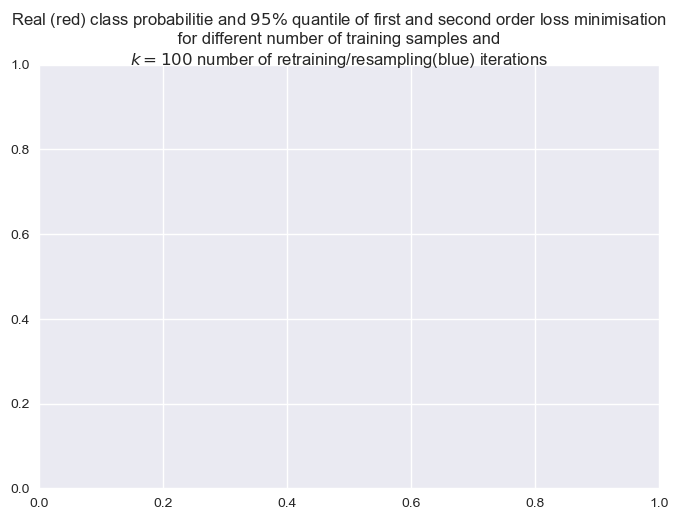

In [26]:
plt.legend()
plt.suptitle("Real (red) class probabilitie and $95\%$ quantile of first and second order loss minimisation \n"
                " for different number of training samples and \n"
                f"$k={{{N_ITER}}}$ number of retraining/resampling(blue) iterations")



Finished first order loss minimnisation training for 1000 samples.
Finished outer loss minimnisation training for 1000 samples.
Finished outer loss minimnisation with regularization training for 1000 samples.
Finished inner loss minimnisation training for 1000 samples.
Finished inner loss minimnisation with regularization training for 1000 samples.
Finished first order loss minimnisation training for 5000 samples.
Finished outer loss minimnisation training for 5000 samples.
Finished outer loss minimnisation with regularization training for 5000 samples.
Finished inner loss minimnisation training for 5000 samples.
Finished inner loss minimnisation with regularization training for 5000 samples.


Text(0.5, 0.98, 'Real (red) class probabilitie and $95\\%$ quantile of first and second order loss minimisation \n for different number of training samples and sample densities, \n$k={100}$ number of retraining/resampling(blue) iterations')

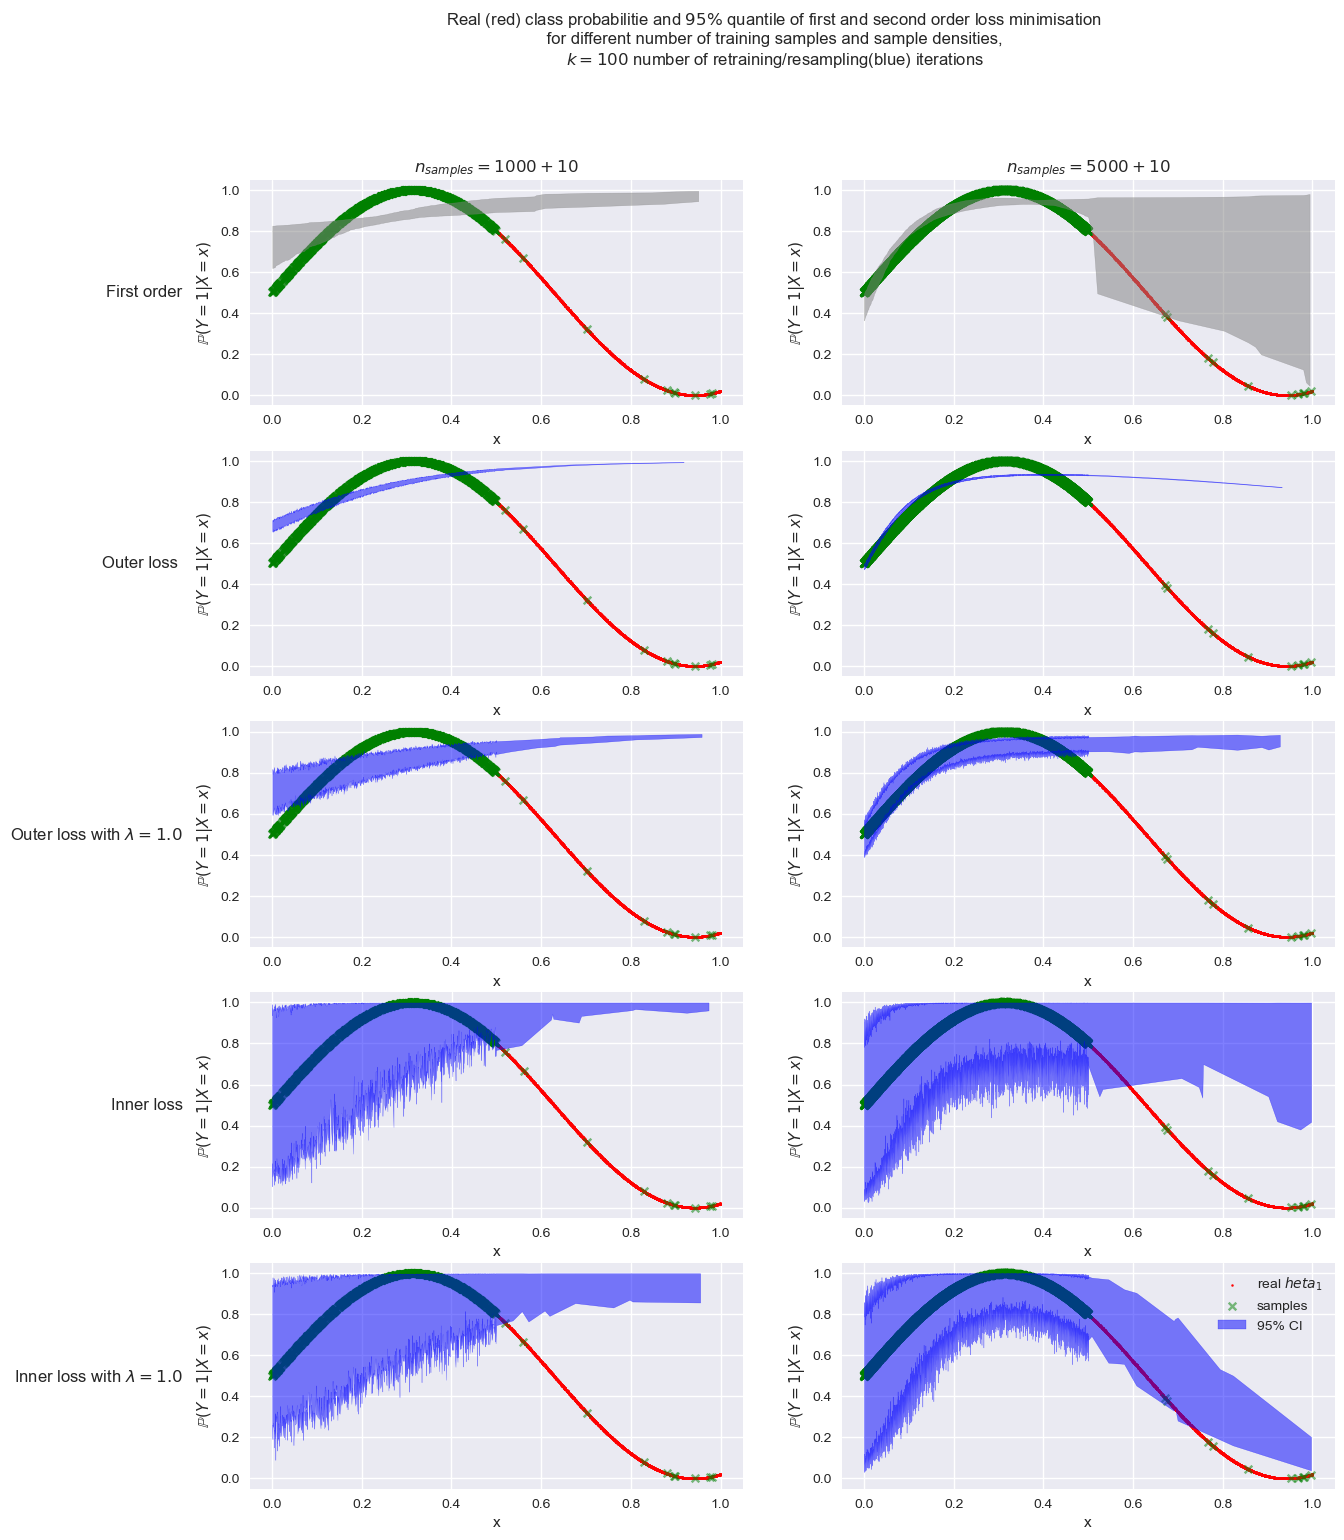

In [27]:

N_SAMPLES_LIST = [1000, 5000]
N_ITER = 150
fig, ax = plt.subplots(5, 2, figsize=(14, 17))
# set x and y labels
plt.setp(ax.flat, xlabel='x', ylabel='$\mathbb{P}(Y=1|X=x)$')
row_names = ["First order", "Outer loss ", f"Outer loss with $\lambda={{{lambda_reg}}}$", "Inner loss", f"Inner loss with $\lambda={{{lambda_reg}}}$"]

# set row and column labels
for ax_sub, col in zip(ax[0], N_SAMPLES_LIST):
    ax_sub.annotate(f'$n_{{samples}}= {{{col}}} + 10$', xy=(0.5, 1), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax_sub, row in zip(ax[:,0], row_names):
    ax_sub.annotate(row, xy=(0, 0.5), xytext=(-ax_sub.yaxis.labelpad - 5, 0),
                xycoords=ax_sub.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

# start training -------------------------------------------
for n_samples in N_SAMPLES_LIST:
    dataset = BernoulliSineDatasetsplitted(n_samples_1=n_samples, n_samples_2=10)
    x_inst = dataset.x_inst.numpy().squeeze()
    preds = dataset.preds.numpy().squeeze()
    
    for idx in range(len(row_names)):
        #plot real probabilitites
        ax[idx, N_SAMPLES_LIST.index(n_samples)].scatter(x_inst_eval, preds_eval, color="red", s=2,
                                                              label="real $\theta_1$")
        ax[idx, N_SAMPLES_LIST.index(n_samples)].scatter(x_inst, preds, color="green", s=30,
                                                                label="samples", marker="x", alpha=0.5)
        
    # FIRST ORDER LOSS MINIMISATION -----------------------------------------------
    results_n, x_inst_n = train_multiple_models_primary_loss_beta(dataset=BernoulliSineDatasetsplitted,
                                                                   n_samples=n_samples,
                                                                   n_samples_2=10,
                                                            loss=loss_primary, batch_size=BATCH_SIZE,
                                                            lr=LR, n_epochs=N_EPOCHS, n_runs=N_ITER,)
    # calculate mean and 2.5th and 97.5th percentiles
    results_n_mean = np.mean(results_n, axis=0)
    lower_quantile = np.percentile(results_n, 2.5, axis=0)
    upper_quantile = np.percentile(results_n, 97.5, axis=0)

    # plot them in one subplot
    ax[0, N_SAMPLES_LIST.index(n_samples)].fill_between(x_inst_n[0,:], lower_quantile, upper_quantile,
                      color="gray", alpha=0.5, label="95% CI")
    print(f"Finished first order loss minimnisation training for {n_samples} samples.")

    # OUTER LOSS MINIMISATION WITHOUT REGULARIZATION --------------------------------
    model = BetaNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    dataset = BernoulliSineDatasetsplitted(n_samples_1=n_samples, n_samples_2=10)
    loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    model_out = train_model(model, loader, criterion=loss_outer, n_epochs= N_EPOCHS,
                            optim=optimizer)
    alphas, betas = model(torch.sort(dataset.x_inst)[0].view(-1,1))
    # sample multiple times from the induced beta distribution

    results_n = sample_predictions_secondary_beta(alphas, betas, n_samplings=N_ITER)
    x_inst = np.ones_like(results_n)*torch.sort(dataset.x_inst)[0].numpy().squeeze()

    # calculate mean and 2.5th and 97.5th percentiles
    results_n_mean = np.mean(results_n, axis=0)
    lower_quantile = np.percentile(results_n, 2.5, axis=0)
    upper_quantile = np.percentile(results_n, 97.5, axis=0)

    # plot them in one subplot
    ax[1, N_SAMPLES_LIST.index(n_samples)].fill_between(x_inst[0,:], lower_quantile, upper_quantile,
                        color="blue", alpha=0.5, label="95% CI")
    print(f"Finished outer loss minimnisation training for {n_samples} samples.")

    # OUTER LOSS MINIMISATION WITH REGULARIZATION --------------------------------
    model = BetaNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    dataset = BernoulliSineDatasetsplitted(n_samples_1=n_samples, n_samples_2=10)
    loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    model_out = train_model(model, loader, criterion=loss_outer_reg, n_epochs= N_EPOCHS,
                            optim=optimizer)
    alphas, betas = model(torch.sort(dataset.x_inst)[0].view(-1,1))
    # sample multiple times from the induced beta distribution
    results_n = sample_predictions_secondary_beta(alphas, betas, n_samplings=N_ITER)
    x_inst = np.ones_like(results_n)*torch.sort(dataset.x_inst)[0].numpy().squeeze()

    # calculate mean and 2.5th and 97.5th percentiles
    results_n_mean = np.mean(results_n, axis=0)
    lower_quantile = np.percentile(results_n, 2.5, axis=0)
    upper_quantile = np.percentile(results_n, 97.5, axis=0)

    # plot them in one subplot
    ax[2, N_SAMPLES_LIST.index(n_samples)].fill_between(x_inst[0,:], lower_quantile, upper_quantile,
                        color="blue", alpha=0.5, label="95% CI")
    
    print(f"Finished outer loss minimnisation with regularization training for {n_samples} samples.")

    # INNER LOSS MINIMISATION WITHOUT REGULARIZATION --------------------------------
    model = BetaNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    dataset = BernoulliSineDatasetsplitted(n_samples_1=n_samples, n_samples_2=10)
    loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    model_out = train_model(model, loader, criterion=loss_inner, n_epochs= N_EPOCHS,
                            optim=optimizer)
    alphas, betas = model(torch.sort(dataset.x_inst)[0].view(-1,1))
    # sample multiple times from the induced beta distribution
    results_n = sample_predictions_secondary_beta(alphas, betas, n_samplings=N_ITER)
    x_inst = np.ones_like(results_n)*torch.sort(dataset.x_inst)[0].numpy().squeeze()

    # calculate mean and 2.5th and 97.5th percentiles
    results_n_mean = np.mean(results_n, axis=0)
    lower_quantile = np.percentile(results_n, 2.5, axis=0)
    upper_quantile = np.percentile(results_n, 97.5, axis=0)

    # plot them in one subplot
    ax[3, N_SAMPLES_LIST.index(n_samples)].fill_between(x_inst[0,:], lower_quantile, upper_quantile,
                        color="blue", alpha=0.5, label="95% CI")
    
    print(f"Finished inner loss minimnisation training for {n_samples} samples.")

    # INNER LOSS MINIMISATION WITH REGULARIZATION --------------------------------
    model = BetaNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    dataset = BernoulliSineDatasetsplitted(n_samples_1=n_samples, n_samples_2=10)
    loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    model_out = train_model(model, loader, criterion=loss_inner_reg, n_epochs= N_EPOCHS,
                            optim=optimizer)
    alphas, betas = model(torch.sort(dataset.x_inst)[0].view(-1,1))
    # sample multiple times from the induced beta distribution
    results_n = sample_predictions_secondary_beta(alphas, betas, n_samplings=N_ITER)
    x_inst = np.ones_like(results_n)*torch.sort(dataset.x_inst)[0].numpy().squeeze()

    # calculate mean and 2.5th and 97.5th percentiles
    results_n_mean = np.mean(results_n, axis=0)
    lower_quantile = np.percentile(results_n, 2.5, axis=0)
    upper_quantile = np.percentile(results_n, 97.5, axis=0)

    # plot them in one subplot
    ax[4, N_SAMPLES_LIST.index(n_samples)].fill_between(x_inst[0,:], lower_quantile, upper_quantile,
                        color="blue", alpha=0.5, label="95% CI")
    
    print(f"Finished inner loss minimnisation with regularization training for {n_samples} samples.")

plt.legend()
plt.suptitle("Real (red) class probabilitie and $95\%$ quantile of first and second order loss minimisation \n"
                " for different number of training samples and sample densities, \n"
                f"$k={{{N_ITER}}}$ number of retraining/resampling(blue) iterations")

        

In [28]:
lower_quantile

array([0.04213658, 0.03833567, 0.06315977, ..., 0.19045646, 0.16148127,
       0.03990335])

Finished first order loss minimnisation training for 1000 samples.
Finished outer loss minimnisation training for 1000 samples.
Finished outer loss minimnisation with regularization training for 1000 samples.
Finished inner loss minimnisation training for 1000 samples.
Finished inner loss minimnisation with regularization training for 1000 samples.
Finished first order loss minimnisation training for 5000 samples.
Finished outer loss minimnisation training for 5000 samples.
Finished outer loss minimnisation with regularization training for 5000 samples.
Finished inner loss minimnisation training for 5000 samples.
Finished inner loss minimnisation with regularization training for 5000 samples.


Text(0.5, 0.98, 'Real (red) class probabilitie and $95\\%$ quantile of first and second order loss minimisation \n for different number of training samples and sample densities, \n$k={150}$ number of retraining/resampling(blue) iterations')

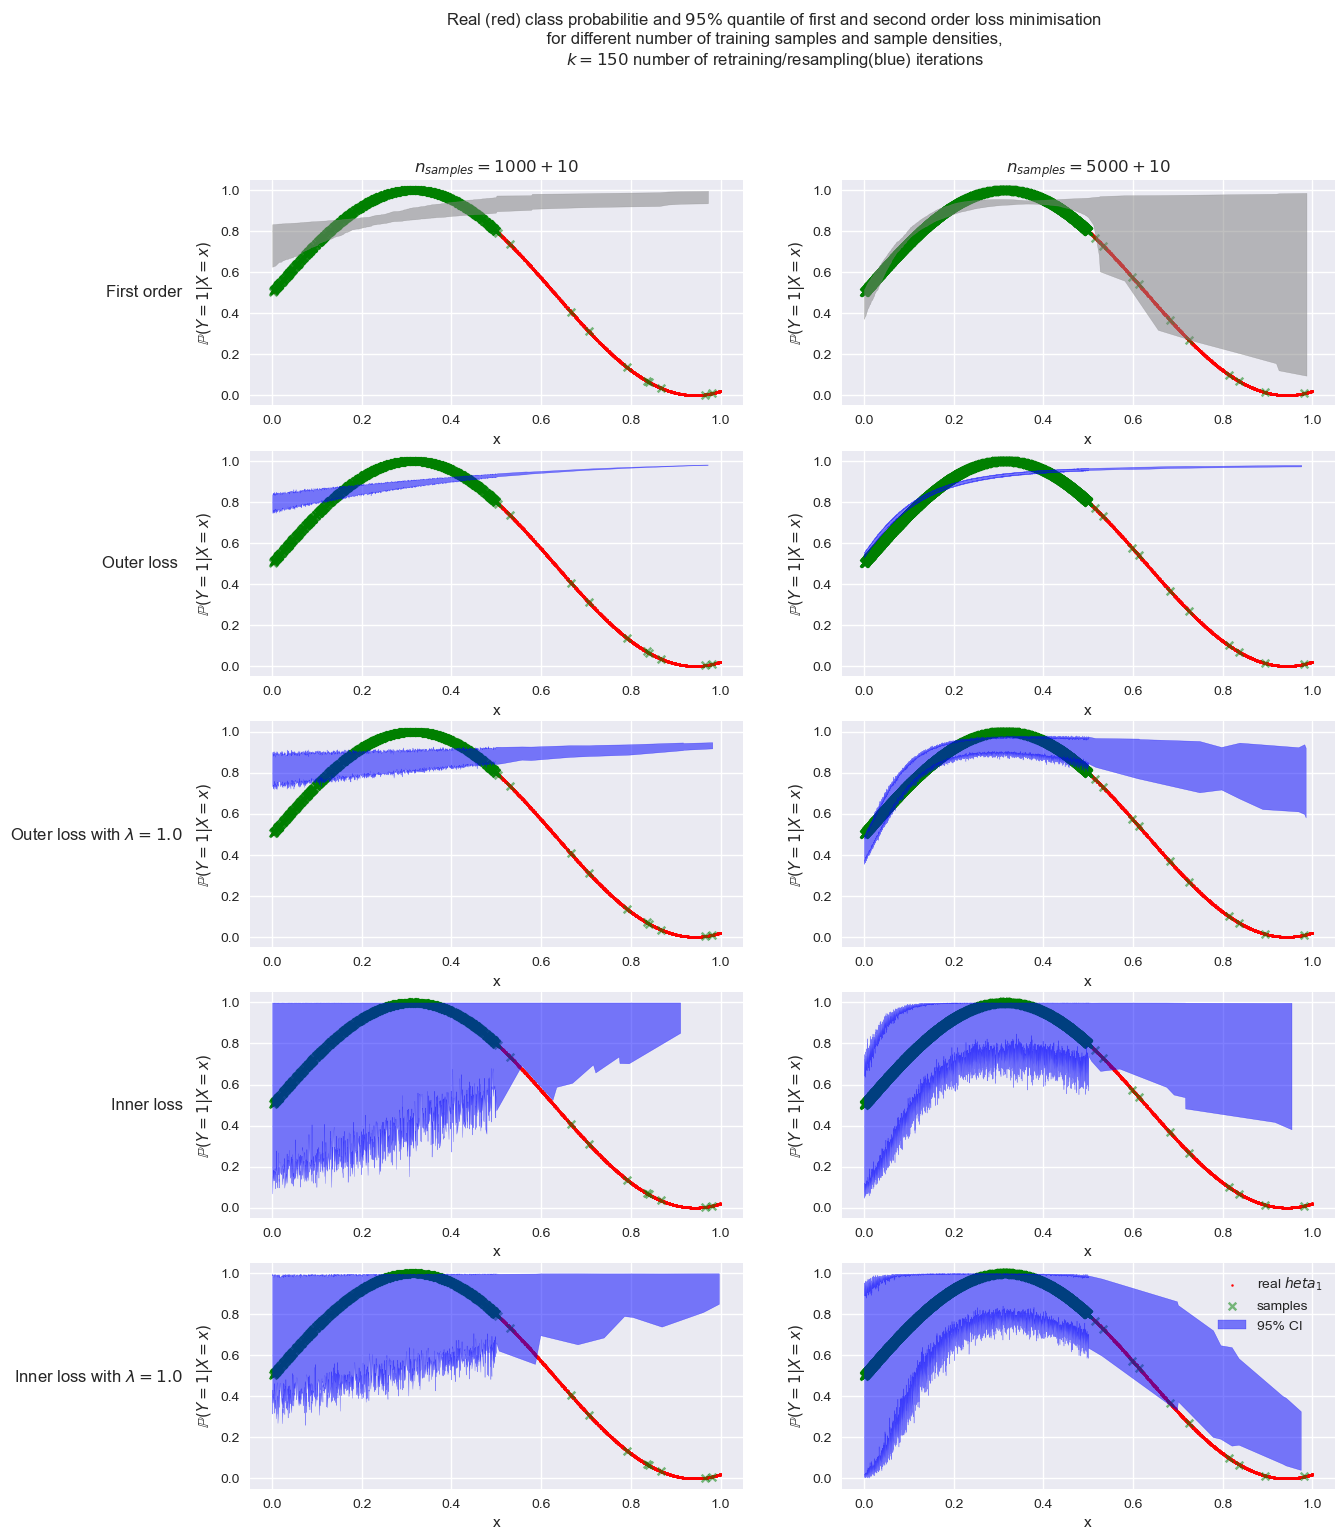

In [29]:

N_SAMPLES_LIST = [1000, 5000]
N_ITER = 150
fig, ax = plt.subplots(5, 2, figsize=(14, 17))
# set x and y labels
plt.setp(ax.flat, xlabel='x', ylabel='$\mathbb{P}(Y=1|X=x)$')
row_names = ["First order", "Outer loss ", f"Outer loss with $\lambda={{{lambda_reg}}}$", "Inner loss", f"Inner loss with $\lambda={{{lambda_reg}}}$"]

# set row and column labels
for ax_sub, col in zip(ax[0], N_SAMPLES_LIST):
    ax_sub.annotate(f'$n_{{samples}}= {{{col}}} + 10$', xy=(0.5, 1), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax_sub, row in zip(ax[:,0], row_names):
    ax_sub.annotate(row, xy=(0, 0.5), xytext=(-ax_sub.yaxis.labelpad - 5, 0),
                xycoords=ax_sub.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

# start training -------------------------------------------
for n_samples in N_SAMPLES_LIST:
    dataset = BernoulliSineDatasetsplitted(n_samples_1=n_samples, n_samples_2=10)
    x_inst = dataset.x_inst.numpy().squeeze()
    preds = dataset.preds.numpy().squeeze()
    
    for idx in range(len(row_names)):
        #plot real probabilitites
        ax[idx, N_SAMPLES_LIST.index(n_samples)].scatter(x_inst_eval, preds_eval, color="red", s=2,
                                                              label="real $\theta_1$")
        ax[idx, N_SAMPLES_LIST.index(n_samples)].scatter(x_inst, preds, color="green", s=30,
                                                                label="samples", marker="x", alpha=0.5)
        
    # FIRST ORDER LOSS MINIMISATION -----------------------------------------------
    results_n, x_inst_n = train_multiple_models_primary_loss_beta(dataset=BernoulliSineDatasetsplitted,
                                                                   n_samples=n_samples,
                                                                   n_samples_2=10,
                                                            loss=loss_primary, batch_size=BATCH_SIZE,
                                                            lr=LR, n_epochs=N_EPOCHS, n_runs=N_ITER,)
    # calculate mean and 2.5th and 97.5th percentiles
    results_n_mean = np.mean(results_n, axis=0)
    lower_quantile = np.percentile(results_n, 2.5, axis=0)
    upper_quantile = np.percentile(results_n, 97.5, axis=0)

    # plot them in one subplot
    ax[0, N_SAMPLES_LIST.index(n_samples)].fill_between(x_inst_n[0,:], lower_quantile, upper_quantile,
                      color="gray", alpha=0.5, label="95% CI")
    print(f"Finished first order loss minimnisation training for {n_samples} samples.")

    # OUTER LOSS MINIMISATION WITHOUT REGULARIZATION --------------------------------
    model = BetaNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    dataset = BernoulliSineDatasetsplitted(n_samples_1=n_samples, n_samples_2=10)
    loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    model_out = train_model(model, loader, criterion=loss_outer, n_epochs= N_EPOCHS,
                            optim=optimizer)
    alphas, betas = model(torch.sort(dataset.x_inst)[0].view(-1,1))
    # sample multiple times from the induced beta distribution

    results_n = sample_predictions_secondary_beta(alphas, betas, n_samplings=N_ITER)
    x_inst = np.ones_like(results_n)*torch.sort(dataset.x_inst)[0].numpy().squeeze()

    # calculate mean and 2.5th and 97.5th percentiles
    results_n_mean = np.mean(results_n, axis=0)
    lower_quantile = np.percentile(results_n, 2.5, axis=0)
    upper_quantile = np.percentile(results_n, 97.5, axis=0)

    # plot them in one subplot
    ax[1, N_SAMPLES_LIST.index(n_samples)].fill_between(x_inst[0,:], lower_quantile, upper_quantile,
                        color="blue", alpha=0.5, label="95% CI")
    print(f"Finished outer loss minimnisation training for {n_samples} samples.")

    # OUTER LOSS MINIMISATION WITH REGULARIZATION --------------------------------
    model = BetaNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    dataset = BernoulliSineDatasetsplitted(n_samples_1=n_samples, n_samples_2=10)
    loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    model_out = train_model(model, loader, criterion=loss_outer_reg, n_epochs= N_EPOCHS,
                            optim=optimizer)
    alphas, betas = model(torch.sort(dataset.x_inst)[0].view(-1,1))
    # sample multiple times from the induced beta distribution
    results_n = sample_predictions_secondary_beta(alphas, betas, n_samplings=N_ITER)
    x_inst = np.ones_like(results_n)*torch.sort(dataset.x_inst)[0].numpy().squeeze()

    # calculate mean and 2.5th and 97.5th percentiles
    results_n_mean = np.mean(results_n, axis=0)
    lower_quantile = np.percentile(results_n, 2.5, axis=0)
    upper_quantile = np.percentile(results_n, 97.5, axis=0)

    # plot them in one subplot
    ax[2, N_SAMPLES_LIST.index(n_samples)].fill_between(x_inst[0,:], lower_quantile, upper_quantile,
                        color="blue", alpha=0.5, label="95% CI")
    
    print(f"Finished outer loss minimnisation with regularization training for {n_samples} samples.")

    # INNER LOSS MINIMISATION WITHOUT REGULARIZATION --------------------------------
    model = BetaNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    dataset = BernoulliSineDatasetsplitted(n_samples_1=n_samples, n_samples_2=10)
    loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    model_out = train_model(model, loader, criterion=loss_inner, n_epochs= N_EPOCHS,
                            optim=optimizer)
    alphas, betas = model(torch.sort(dataset.x_inst)[0].view(-1,1))
    # sample multiple times from the induced beta distribution
    results_n = sample_predictions_secondary_beta(alphas, betas, n_samplings=N_ITER)
    x_inst = np.ones_like(results_n)*torch.sort(dataset.x_inst)[0].numpy().squeeze()

    # calculate mean and 2.5th and 97.5th percentiles
    results_n_mean = np.mean(results_n, axis=0)
    lower_quantile = np.percentile(results_n, 2.5, axis=0)
    upper_quantile = np.percentile(results_n, 97.5, axis=0)

    # plot them in one subplot
    ax[3, N_SAMPLES_LIST.index(n_samples)].fill_between(x_inst[0,:], lower_quantile, upper_quantile,
                        color="blue", alpha=0.5, label="95% CI")
    
    print(f"Finished inner loss minimnisation training for {n_samples} samples.")

    # INNER LOSS MINIMISATION WITH REGULARIZATION --------------------------------
    model = BetaNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    dataset = BernoulliSineDatasetsplitted(n_samples_1=n_samples, n_samples_2=10)
    loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    model_out = train_model(model, loader, criterion=loss_inner_reg, n_epochs= N_EPOCHS,
                            optim=optimizer)
    alphas, betas = model(torch.sort(dataset.x_inst)[0].view(-1,1))
    # sample multiple times from the induced beta distribution
    results_n = sample_predictions_secondary_beta(alphas, betas, n_samplings=N_ITER)
    x_inst = np.ones_like(results_n)*torch.sort(dataset.x_inst)[0].numpy().squeeze()

    # calculate mean and 2.5th and 97.5th percentiles
    results_n_mean = np.mean(results_n, axis=0)
    lower_quantile = np.percentile(results_n, 2.5, axis=0)
    upper_quantile = np.percentile(results_n, 97.5, axis=0)

    # plot them in one subplot
    ax[4, N_SAMPLES_LIST.index(n_samples)].fill_between(x_inst[0,:], lower_quantile, upper_quantile,
                        color="blue", alpha=0.5, label="95% CI")
    
    print(f"Finished inner loss minimnisation with regularization training for {n_samples} samples.")

plt.legend()
plt.suptitle("Real (red) class probabilitie and $95\%$ quantile of first and second order loss minimisation \n"
                " for different number of training samples and sample densities, \n"
                f"$k={{{N_ITER}}}$ number of retraining/resampling(blue) iterations")

        